# Logistic Regression Using Retail Relay Data

This notebook will demonstrate predicting customer retention using logistic regression.

Assignment Questions:

1. Use the Relay data to develop a model to predict customer retention. You may use logistic regression to predict the variable “retained.” You can use any combination of the independent variables available in the data to obtain a model
with the best predictive ability and usability. You are free to use different transformations and combinations of the independent variables. Be aware that there is no “magic bullet” to finding the ideal model. You will have to go through multiple iterations.

2. Split the data into test and train. Generally, 70% of the data is used to train the model and a hold out sample of 30% is used to test the accuracy of the model.

3. Create the first model with all the variables that can be used in the given data set. Interpret the coefficients in a real-world sense.

4. Once you obtain the best model that you can find, predict retention in the test data. You will use the logistic regression coefficients obtained from the train data to do this. This new variable will be the predicted value of retained.

5. Calculate the hit rate. This can be calculated as % of matches between the value of the variable “retained” and the predicted value of “retained” in the test data.


In [1]:
import os
import pandas as pd 
import numpy as np 
from sklearn import preprocessing
#import matplotlib.pyplot as plt 
#plt.rc('font', size = 14)
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
import seaborn as sns 
sns.set(style = 'white')
sns.set(style = 'whitegrid', color_codes = True)
#import warnings
#warnings.filterwarnings('ignore', category = FutureWarning)

## Read Data

In [2]:
fname = "Relay_Data.xlsx"
df = pd.read_excel(fname, sheet_name=2)

In [3]:
# top 5 observations
df.head()

,custid,retained,created,firstorder,lastorder,esent,eopenrate,eclickrate,avgorder,ordfreq,paperless,refill,doorstep,favday,city
0,6H6T6N,0,2008-09-27,2009-08-10 00:00:00,2009-08-10 00:00:00,29,100.000000,3.448276,14.52,0.000000,0,0,0,Monday,CHO
1,APCENR,1,2006-12-18,2007-03-31 00:00:00,2010-01-18 00:00:00,95,92.631579,10.526316,83.69,0.181641,1,1,1,Friday,CHO
2,7UP6MS,0,2006-10-02,2006-11-30 00:00:00,2007-07-05 00:00:00,0,0.000000,0.000000,33.58,0.059908,0,0,0,Wednesday,CHO
3,7ZEW8G,0,2006-10-21,2007-03-27 00:00:00,2007-03-27 00:00:00,0,0.000000,0.000000,54.96,0.000000,0,0,0,Thursday,RIC
4,8V726M,1,2006-11-26,2006-11-28 00:00:00,2009-01-27 00:00:00,30,90.000000,13.333333,111.91,0.008850,0,0,0,Monday,RIC


In [4]:
# bottom 5 observations
df.tail()

,custid,retained,created,firstorder,lastorder,esent,eopenrate,eclickrate,avgorder,ordfreq,paperless,refill,doorstep,favday,city
30796,24CY2D,1,2014-01-16,2014-01-16 00:00:00,2014-01-16 00:00:00,6,83.333333,16.666667,55.68,0.0,1,0,1,Friday,DCX
30797,YQK8BU,1,2014-01-16,2014-01-16 00:00:00,2014-01-16 00:00:00,13,69.230769,7.692308,35.00,0.0,1,0,0,Saturday,DCX
30798,TFQRQP,1,2014-01-16,2014-01-16 00:00:00,2014-01-20 00:00:00,8,75.000000,37.500000,52.03,0.5,1,1,0,Saturday,DCX
30799,ZTXM5Y,1,2014-01-16,2014-01-16 00:00:00,2014-01-16 00:00:00,6,33.333333,0.000000,40.20,0.0,1,0,0,Friday,RIC
30800,HXF9P5,1,2014-01-16,2014-01-16 00:00:00,2014-01-16 00:00:00,5,40.000000,20.000000,40.00,0.0,1,0,0,Friday,DCX


In [5]:
df.shape

(30801, 15)

In [6]:
# columns and their data types
df.dtypes

custid                object
retained               int64
created       datetime64[ns]
firstorder            object
lastorder             object
esent                  int64
eopenrate            float64
eclickrate           float64
avgorder             float64
ordfreq              float64
paperless              int64
refill                 int64
doorstep               int64
favday                object
city                  object
dtype: object

### The dataset contains 30801 observations of 15 variables
* The target variable is called 'retained'
* There are several variables that may not be useful to include in the regression model itself such as:
    * custid (ID), created (Datetime), firstorder (Datetime), lastorder (Datetime)
    * firstorder and lastorder should be Datetime format, but they come encoded as 'object' type.
    * Although these may not end up in the regression model, it might be good to explore the data visually using these variables in conjunction with the target variable 'retained'. 
* Some preprocessing and exploration is definitely in scope given the data.
* There are two 'object' type variables 'favday' and 'city', which may be useful to include in the regression model. These should be one-hot-encoded to create dummy variables for modeling.

## Data Dictionary
* **custid**:       Computer generated ID to identify customers throughout the database
* **retained**:     1, if customer is assumed to be active, 0 = otherwise
* **created**:	    Date when the contact was created in the database - when the customer joined
* **firstorder**:	Date when the customer placed first order
* **lastorder**:	Date when the customer placed last order
* **esent**:    	Number of emails sent
* **eopenrate**:	Number of emails opened divided by number of emails sent
* **eclickrate**:	Number of emails clicked divided by number of emails sent
* **avgorder**: 	Average order size for the customer
* **ordfreq**:  	Number of orders divided by customer tenure
* **paperless**:	1 if customer subscribed for paperless communication (only online)
* **refill**:   	1 if customer subscribed for automatic refill
* **doorstep**: 	1 if customer subscribed for doorstep delivery
* **favday**:   	Customer's favorite delivery day
* **city**:     	City where the customer resides in


## Validate 'custid' is unique

In [7]:
print("There are {:d} total observations".format(df.shape[0]))

There are 30801 total observations


In [8]:
print("There are {:d} unique customer ids".format(len(set(df.custid))))

There are 30770 unique customer ids


### Customer ID is in fact not the unique identifier of this dataset

## Check for Missing Data

In [9]:
# count of missing values by column
df.isna().sum()

custid        20
retained       0
created       20
firstorder    20
lastorder     20
esent          0
eopenrate      0
eclickrate     0
avgorder       0
ordfreq        0
paperless      0
refill         0
doorstep       0
favday         0
city           0
dtype: int64

### There are exactly 20 missing values in each of these variables:
* 'custid','created','firstorder','lastorder'
* The following observations contain missing values in these variables
* For the purposes of this demonstration, these observations will still be used for logistic regression modeling as the target variable and proposed independent variables do not contain any missing values.

In [10]:
missing_data = df[df.isnull().any(axis = 1)]
missing_data.shape

(20, 15)

## Check for duplicate observations

In [11]:
df = df.reset_index()
df.loc[df.duplicated(keep = False)]

,index,custid,retained,created,firstorder,lastorder,esent,eopenrate,eclickrate,avgorder,ordfreq,paperless,refill,doorstep,favday,city


### The dataset does not contain any duplicated observations

## Count of unique values by variable

In [12]:
[col + ' ' + str(df[col].nunique()) for col in list(df.columns)]

['index 30801',
 'custid 30769',
 'retained 2',
 'created 2821',
 'firstorder 2672',
 'lastorder 2414',
 'esent 90',
 'eopenrate 977',
 'eclickrate 503',
 'avgorder 9937',
 'ordfreq 4388',
 'paperless 2',
 'refill 2',
 'doorstep 2',
 'favday 7',
 'city 4']

### The following independent variables are categorical in nature:
* 'paperless' - binary
* 'refill 2' - binary
* 'doorstep' - binary
* 'favday' - categorical 7-levels
* 'city' - categorical 4-levels

## Check for Class Imbalance in Target Variable 'retained'

In [13]:
df['retained'].value_counts()

1    24472
0     6329
Name: retained, dtype: int64

In [14]:
24472 / (24472+6329)

0.7945196584526476

### There is a class imbalance in the Target Variable 'retained'. 80% of observations are 'retained' = 1; 20% of observations are 'retained' = 0. Due to the class imbalance, it will be necessary to perform resampling to balance the classes prior to modeling.

## Explore Average Values by Class
* For each target class label, compute the average value of each independent variable

In [15]:
df.columns

Index(['index', 'custid', 'retained', 'created', 'firstorder', 'lastorder',
       'esent', 'eopenrate', 'eclickrate', 'avgorder', 'ordfreq', 'paperless',
       'refill', 'doorstep', 'favday', 'city'],
      dtype='object')

In [16]:
# variables for modeling
these_vars = ['retained','esent','eopenrate','eclickrate','avgorder','ordfreq']
df[these_vars].groupby('retained').mean()

,esent,eopenrate,eclickrate,avgorder,ordfreq
retained,,,,,
0,4.496919,21.207903,4.785196,61.550188,0.035523
1,34.252615,26.679051,5.900263,61.957675,0.038299


### On average:
* 'esent' (number of emails sent to customer) is substantially higher for retained customers than for non-retained customers.
    * **Retained customers were sent 34 emails on average versus 4 emails for non-retained customers**
* 'eopenrate' (emails opened) and 'eclickrate' (emails clicked) are slightly higher as well for retained customers than for non-retained customers.
* 'avgorder' (average order size) is similar for retained customers and non-retained customers. This doesn't appear to be a very distinguishing factor.
* 'ordfreq' (ratio of number of orders to customer tenure) is also similar between retained and non-retained customers.


## Visualize Distributions of Variables by Retained and Non-Retained Customers
* For each of the variables ('esent','eopenrate','eclickrate','avgorder','ordfreq') assess how different the distributions are for retained vs. non-retained customers

### Number of Emails Sent by 'retained'

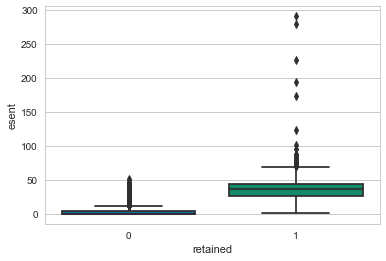

In [17]:
sns.boxplot(y = 'esent', x = 'retained', data = df, palette='colorblind')

### Number of Emails Opened by 'retained'

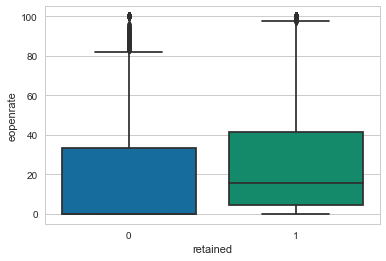

In [18]:
sns.boxplot(y = 'eopenrate', x = 'retained', data = df, palette = 'colorblind')

### Number of Emails Clicked by 'retained'

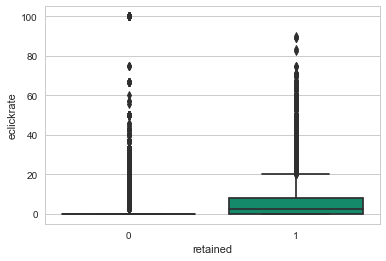

In [20]:
sns.boxplot(y = 'eclickrate', x = 'retained', data = df, palette = 'colorblind')

### Average Order Size by 'retained'

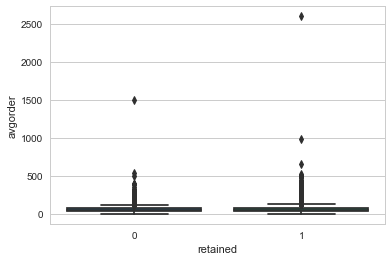

In [19]:
sns.boxplot(y = 'avgorder', x = 'retained', data = df, palette = 'colorblind')

### Order Frequency by 'retained'

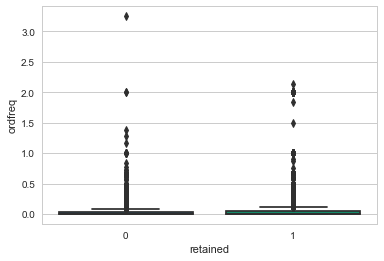

In [21]:
sns.boxplot(y = 'ordfreq', x = 'retained', data = df, palette = 'colorblind')